In [2]:
from mppi import Utilities as U, Parsers as P
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import numpy as np

# Plots

The notebook collects the plots used in the paper

## KS Bands and DOS

In [129]:
bands_file = 'QE_bands/bands.save/data-file-schema.xml'
dos_file = 'NSCF/bnds_16-kpoints_8.save/data-file-schema.xml'
dosKpump_file = 'NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml'

hsp = U.high_sym_fcc

In [130]:
bands = U.BandStructure.from_Pw(bands_file,hsp,set_gap=1.42)

Apply a scissor of 0.5446695074337246 eV


In [131]:
hs_positions = bands.get_high_sym_positions()
print(hs_positions)

kspan = 0.05 #in unit of 2pi/alat
k0 = 0.8660254037844385

(['G', 'G', 'X', 'L', 'K'], [0.8660254037844385, 4.28023896615753, 1.8660254037844377, 0.0, 2.866025403784435])


In [132]:
dos = U.Dos.from_Pw(dos_file,set_gap=1.42,label='dos',eta=0.05,minVal=-4,maxVal=4)
dos.append_fromPw(dosKpump_file,set_gap=1.42,label='dosKpump',eta=0.01,minVal=-4,maxVal=4)

Apply a scissor of 0.5446694952016056 eV
Apply a scissor of 0.5456147497318283 eV


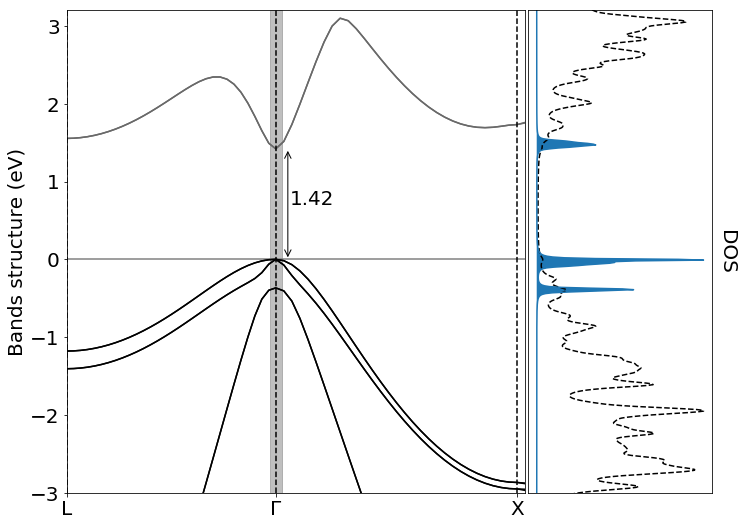

In [133]:
ymax = 3.2
ymin = -3.
label_size = 20

fig = plt.figure(figsize=(10, 7)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[2.5, 1]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

# script for the bands
path = bands.get_path()
labels,positions = bands.get_high_sym_positions()
val_bands = [2,3,4,5,6,7]
cond_bands = [8,9]
for ind in val_bands:
    ax0.plot(path,bands.bands[ind],color='black')
for ind in cond_bands:
    ax0.plot(path,bands.bands[ind],color='dimgray')
    
for pos in positions:
    ax0.axvline(pos,color='black',ls='--')
lb = []
for l in labels:
    if l == 'G': lb.append('$\Gamma$')
    else: lb.append(l)
#ax0.arrow(k0+0.1,0.,0.,1.4)
ax0.annotate('', xy=(k0+0.05, 0), xytext=(k0+0.05, 1.42), arrowprops=dict(arrowstyle='<->'),size=16)
ax0.text(k0+0.06,0.7,'1.42',size=label_size)
ax0.set_xticklabels(lb,size=label_size)
ax0.set_xticks(positions)
ax0.set_ylim(ymin,ymax)
ax0.set_xlim(0,1.9)
ax0.set_ylabel('Bands structure (eV)',size=label_size)
ax0.axvspan(k0-kspan/2, k0+kspan/2, alpha=0.5, color='gray')
ax0.hlines(0.,0.,2,linestyles='-',color='gray')
ax0.tick_params(axis='both', which='major', labelsize=label_size)

# script for the dos
scale = max(dos.dos[0][1])
ax1.plot(dos.dos[0][1]/scale,dos.dos[0][0],linestyle='--',color='black')
scale = max(dos.dos[1][1])
ax1.plot(dos.dos[1][1]/scale,dos.dos[1][0],color='tab:blue')
ax1.fill_between(dos.dos[1][1]/scale,dos.dos[1][0], 0)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_ylim(ymin,ymax)
ax1.set_ylabel('DOS',size=label_size,rotation=270)
ax1.yaxis.set_label_coords(1.03,0.5)

plt.tight_layout(pad=-0.4)

#plt.savefig(fname='bands_dos_LGX.eps',format='eps',bbox_inches = "tight")
plt.show()

## Absorption and JDOS

We read the experimental n and k parameters and build the experimental $\epsilon_2$

In [3]:
from pandas_ods_reader import read_ods

In [4]:
abs_data = read_ods('GaAs_nk.ods', 1, columns=['energy', 'n', 'k'])

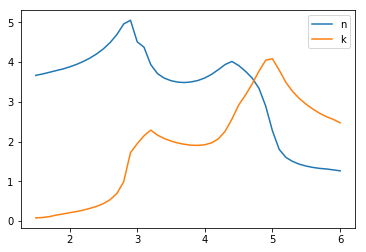

In [5]:
plt.plot(abs_data.energy,abs_data.n,label='n')
plt.plot(abs_data.energy,abs_data.k,label='k')
plt.legend()

In [6]:
energy_exp = np.array(abs_data.energy)
eps2_exp = 2.*np.array(abs_data.n)*np.array(abs_data.k)**2

In [7]:
r_100 = P.PwParser('NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml')

Parse file : NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml


In [8]:
weights_100 = r_100.weights

In [9]:
transitions_100 = r_100.get_transitions(set_gap=1.42,initial=[4,5,6,7],final=[8,9])

Apply a scissor of 0.5456147497318283 eV


In [10]:
dos = U.Dos()
dos.append_fromPwData(transitions_100,weights_100,minVal=1,maxVal=3,eta=0.004,label='JDOS')

In [11]:
dos.append(energies=np.array([1.5]),norm=8,eta=0.04,minVal=1,maxVal=3,label='Field',broad_kind=U.gaussian)

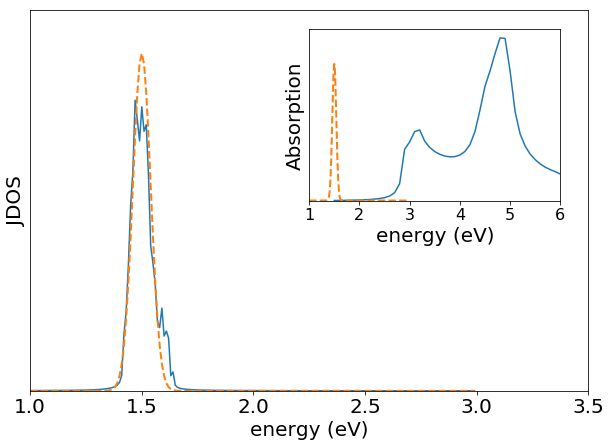

In [13]:
ymax = 90
label_size = 20

fig, ax1 = plt.subplots(figsize=(10, 7))

ax1.plot(dos.dos[0][0],dos.dos[0][1], label='JDOS')
ax1.plot(dos.dos[1][0],dos.dos[1][1], label='Field',linestyle='--',linewidth=2)
ax1.set_xlabel('energy (eV)',size=label_size)
ax1.set_ylabel('JDOS',size=label_size)
ax1.set_xlim(1,3.5)
ax1.set_ylim(0,ymax)
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.5,0.5,0.45,0.45])
ax2.set_axes_locator(ip)
ax2.plot(energy_exp,eps2_exp)
ax2.plot(dos.dos[1][0],dos.dos[1][1], label='Field',linestyle='--',linewidth=2)
ax2.set_ylabel('Absorption',size=label_size)
ax2.set_yticks([])
ax2.set_xlabel('energy (eV)',size=label_size)
ax2.set_ylim(0,100)
ax2.set_xlim(1,6)
ax2.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='jdos_cv.eps',format='eps',bbox_inches = "tight")
plt.show()

### IP absorption

We plot the IP absorption spectrum in the main frame of the figure. To build the absorption we compute the
weight of each transition using the square of the matrix element of the dipole

In [14]:
dipoles = U.get_variable_from_db('RT_k100/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_10000/ndb.dipoles','DIP_iR')
dipoles = dipoles[0:100]

In [15]:
def get_dip_squared(dipoles,kpoint,band1,band2,component):
    value = dipoles[kpoint][band1][band2][component]
    return value[0]**2+value[1]**2

In [16]:
def eval_dipole_weights(dipoles,in_list,fin_list,component=2):
    """
    Compute the weight associated the the transitions

    Args:
        dipoles (:py:class:`ndarray`) : array with the dipoles elements
        in_list (list) : indexes of the bands used as starting points of the transitions
        fin_list (list) : indexes of the bands used as final points of the transitions

    Returns:
        transitions (list) : list with the transition energies for each possible couple
        of (distinct) in and out bands
    """
    dip_weights = []
    for k in range(len(dipoles)):
        weights = []
        for v in in_list:
            for c in fin_list:
                if c > v:
                    weights.append(get_dip_squared(dipoles,k,v,c,component))
        dip_weights.append(weights)
    return np.array(dip_weights)

In [17]:
dip_weights = eval_dipole_weights(dipoles,in_list=[0,1,2,3],fin_list=[4,5])

In [18]:
dos = U.Dos()
dos.append(transitions_100.flatten(),dip_weights.flatten(),minVal=1,maxVal=3,eta=0.004,label='Abs')
dos.append(energies=np.array([1.5]),norm=8,eta=0.04,minVal=1,maxVal=3,label='Field',broad_kind=U.gaussian)

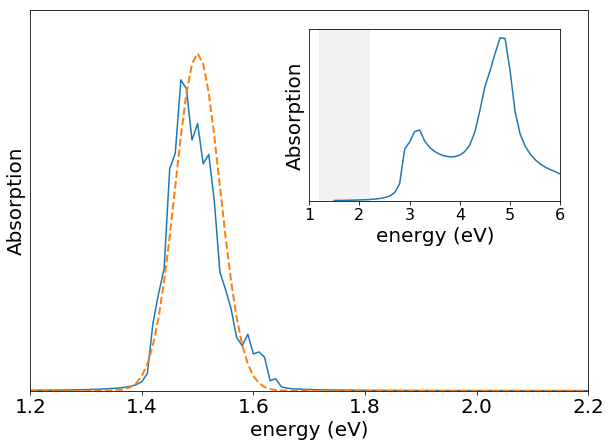

In [62]:
ymax = 90
label_size = 20

fig, ax1 = plt.subplots(figsize=(10, 7))

ax1.plot(dos.dos[0][0],2.6e-4*dos.dos[0][1], label='Abs')
ax1.plot(dos.dos[1][0],dos.dos[1][1], label='Field',linestyle='--',linewidth=2)
ax1.set_xlabel('energy (eV)',size=label_size)
ax1.set_ylabel('Absorption',size=label_size)
ax1.set_xlim(1.2,2.2)
ax1.set_ylim(0,ymax)
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.5,0.5,0.45,0.45])
ax2.set_axes_locator(ip)
ax2.plot(energy_exp,eps2_exp)
#ax2.plot(dos.dos[1][0],dos.dos[1][1], label='Field',linestyle='--',linewidth=2)
ax2.axvspan(1.2, 2.2, alpha=0.2, color='silver')
ax2.set_ylabel('Absorption',size=label_size)
ax2.set_yticks([])
ax2.set_xlabel('energy (eV)',size=label_size)
ax2.set_ylim(0,100)
ax2.set_xlim(1,6)
ax2.tick_params(axis='both', which='major', labelsize=16)

#ax1.annotate("", xy=(1.6, 50), xytext=(1.8, 50),arrowprops=dict(arrowstyle="->"))

plt.savefig(fname='abs_cv.eps',format='eps',bbox_inches = "tight")
plt.show()

## JDOS c-c' and spin splitting

In [2]:
r_50 = P.PwParser('NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml')
r_100 = P.PwParser('NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml')

Parse file : NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml


In [3]:
transitions_50 = 1e3*r_50.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
transitions_100 = 1e3*r_100.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])

Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.5456147497318283 eV


In [4]:
weights_50 = r_50.weights
weights_100 = r_100.weights

In [5]:
jdos = U.Dos()
jdos.append_fromPwData(transitions_50,weights_50,minVal=-2,maxVal=3,eta=0.05,label='$N_k$=50')
jdos.append_fromPwData(transitions_100,weights_100,minVal=-2,maxVal=3,eta=0.05,label='$N_k$=100')

In [6]:
hsp = U.high_sym_fcc
bands = U.BandStructure.from_Pw('QE_bands/bands_G-K.save/data-file-schema.xml',hsp,set_gap=1.42)

Apply a scissor of 0.5446694973756367 eV


In [7]:
path = bands.get_path()
b = bands.get_bands()
spin_splitting = 1e3*(b[9]-b[8]) # in meV

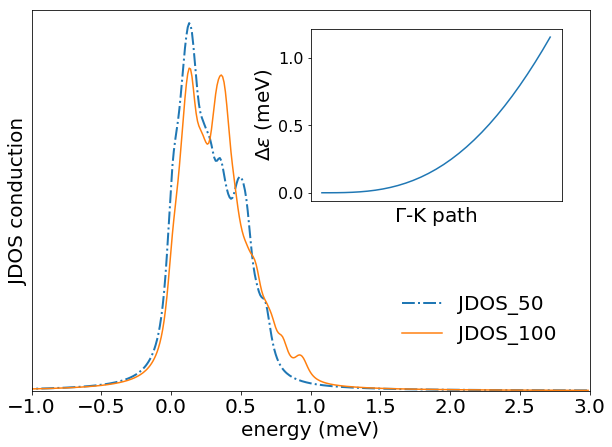

In [8]:
ymax = 2
label_size = 20

fig, ax1 = plt.subplots(figsize=(10, 7))

ax1.plot(jdos.dos[0][0],jdos.dos[0][1], label='JDOS_50',linestyle='-.',linewidth=2)
ax1.plot(jdos.dos[1][0],jdos.dos[1][1], label='JDOS_100')
ax1.set_xlabel('energy (meV)',size=label_size)
ax1.set_ylabel('JDOS conduction',size=label_size)
ax1.set_xlim(-1,3)
ax1.set_ylim(0,ymax)
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.legend(loc=(0.65,0.1),fontsize=label_size,frameon=False)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.5,0.5,0.45,0.45])
ax2.set_axes_locator(ip)
ax2.plot(path,spin_splitting)
ax2.set_ylabel('$\Delta\epsilon$ (meV)',size=label_size)
ax2.set_xticks([])
ax2.set_xlabel('$\Gamma$-K path',size=label_size)
ax2.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='jdos_ccp.eps',format='eps',bbox_inches = "tight")
plt.show()

## JDOS c-c' and spin splitting (with band plot)

In [9]:
r_50 = P.PwParser('NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml')
r_100 = P.PwParser('NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml')

Parse file : NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml


In [10]:
transitions_50 = 1e3*r_50.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
transitions_100 = 1e3*r_100.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])

Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.5456147497318283 eV


In [11]:
weights_50 = r_50.weights
weights_100 = r_100.weights

In [12]:
jdos = U.Dos()
jdos.append_fromPwData(transitions_50,weights_50,minVal=-2,maxVal=3,eta=0.05,label='$N_k$=50')
jdos.append_fromPwData(transitions_100,weights_100,minVal=-2,maxVal=3,eta=0.05,label='$N_k$=100')

In [13]:
hsp = U.high_sym_fcc
bands = U.BandStructure.from_Pw('QE_bands/bands_K-G-K.save/data-file-schema.xml',hsp,set_gap=1.42)

Apply a scissor of 0.5446695036141547 eV


In [30]:
path = bands.get_path()
b = bands.get_bands()
b8 = b[8]-min(b[8])
b9_scaled = b[9]*(1+0.3*abs(path-hp[1][0]))-min(b[9])

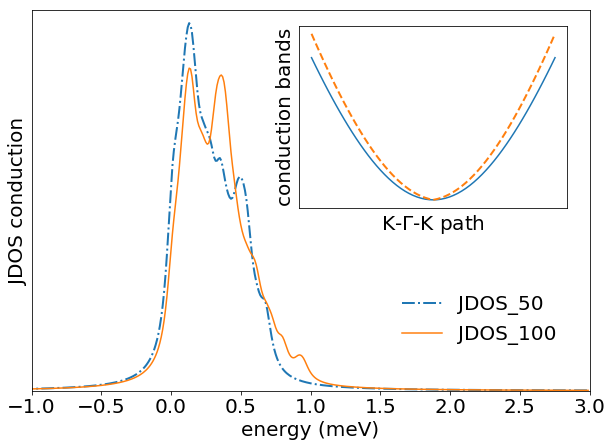

In [42]:
ymax = 2
label_size = 20

fig, ax1 = plt.subplots(figsize=(10, 7))

ax1.plot(jdos.dos[0][0],jdos.dos[0][1], label='JDOS_50',linestyle='-.',linewidth=2)
ax1.plot(jdos.dos[1][0],jdos.dos[1][1], label='JDOS_100')
ax1.set_xlabel('energy (meV)',size=label_size)
ax1.set_ylabel('JDOS conduction',size=label_size)
ax1.set_xlim(-1,3)
ax1.set_ylim(0,ymax)
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)
ax1.legend(loc=(0.65,0.1),fontsize=label_size,frameon=False)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.48,0.48,0.48,0.48])
ax2.set_axes_locator(ip)
ax2.plot(path,b8)
ax2.plot(path,b9_scaled,linestyle='--',linewidth=2)
ax2.set_yticks([])
ax2.set_ylabel('conduction bands',size=label_size)
ax2.set_xticks([])
ax2.set_xlabel('K-$\Gamma$-K path',size=label_size)
ax2.tick_params(axis='both', which='major', labelsize=16)

plt.savefig(fname='jdos_ccp.eps',format='eps',bbox_inches = "tight")
plt.show()

## Spin polarization (dephase all)

Analysis of the spin polarization with dephasing on all the off diagonal matrix elements of the density matrix.
This is done to check the asymptotic value due to the diagonal components

In [82]:
path_100 = 'RT_k100/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_2000-dephase_all'
path_50 = 'RT_k50/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_2000-dephase_all'
path_50_thrsh_1em5 = 'RT_k50/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_2000-dephase_all-thrs_1e-5'
path_50_thrsh_1em6 = 'RT_k50/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_2000-dephase_all-thrs_1e-6'
path_100_thrsh_1em6 = 'RT_k100/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_2000-dephase_all-thrs_1e-6'

In [83]:
data_100 = P.YamboParser.from_path(path_100)
data_50 = P.YamboParser.from_path(path_50)
data_50_thrsh_1em5 = P.YamboParser.from_path(path_50_thrsh_1em5)
data_50_thrsh_1em6 = P.YamboParser.from_path(path_50_thrsh_1em6)
data_100_thrsh_1em6 = P.YamboParser.from_path(path_100_thrsh_1em6)

In [84]:
spin_100 = data_100['spin_magnetization']
spin_50 = data_50['spin_magnetization']
spin_50_thrsh_1em5 = data_50_thrsh_1em5['spin_magnetization']
spin_50_thrsh_1em6 = data_50_thrsh_1em6['spin_magnetization']
spin_100_thrsh_1em6 = data_100_thrsh_1em6['spin_magnetization']

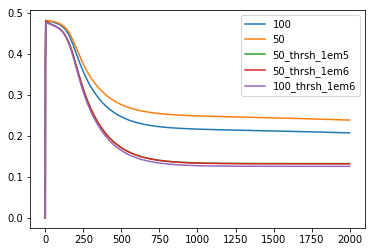

In [85]:
plt.plot(spin_100['time'],spin_100['Mc_z'],label='100')
plt.plot(spin_50['time'],spin_50['Mc_z'],label='50')
plt.plot(spin_50_thrsh_1em5['time'],spin_50_thrsh_1em5['Mc_z'],label='50_thrsh_1em5')
plt.plot(spin_50_thrsh_1em6['time'],spin_50_thrsh_1em6['Mc_z'],label='50_thrsh_1em6')
plt.plot(spin_100_thrsh_1em6['time'],spin_100_thrsh_1em6['Mc_z'],label='100_thrsh_1em6')
plt.legend()

In [40]:
spin_50_thrsh_1em6['Mc_z'][-1]

0.132092935

In [86]:
spin_100_thrsh_1em6['Mc_z'][-1]

0.125880377

## Spin polarization

In [9]:
path_50 = 'RT_k50/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_10000'
path_100 = 'RT_k100/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_10000'
path_50_lowdeph = 'RT_k50/FixSymm/dephase_0.0001-freq_1.5-int_1000.0-simTime_10000'
path_50_longpulse = 'RT_k50/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_10000-fwhm_200'
path_100_thr_1em6 = 'RT_k100/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_10000-thrs_1e-6'
path_100_2e4_thr_1em6 = 'RT_k100/FixSymm/dephase_0.002-freq_1.5-int_1000.0-simTime_20000-thrs_1e-6'
path_1k_maxfeq = 'RT_1k-maxfreq/FixSymm/dephase_0.002-freq_1.53-int_1000.0-simTime_10000/'

In [10]:
data_50 = P.YamboParser.from_path(path_50)
data_100 = P.YamboParser.from_path(path_100)
data_100_thr_1em6 = P.YamboParser.from_path(path_100_thr_1em6)
data_100_2e4_thr_1em6 = P.YamboParser.from_path(path_100_2e4_thr_1em6)
data_1k_maxfreq = P.YamboParser.from_path(path_1k_maxfeq)

In [11]:
carr_50 = data_50['carriers']
carr_100 = data_100['carriers']
carr_1k_maxfreq = data_1k_maxfreq['carriers']
field_50 = data_50['external_field']
field_100 = data_100['external_field']
spin_50 = data_50['spin_magnetization']
spin_100 = data_100['spin_magnetization']
spin_100_thr_1em6 = data_100_thr_1em6['spin_magnetization']
spin_100_2e4_thr_1em6 = data_100_2e4_thr_1em6['spin_magnetization']
spin_1k_maxfreq = data_1k_maxfreq['spin_magnetization']

### Plot of the spin polarization with a low dephase in conduction

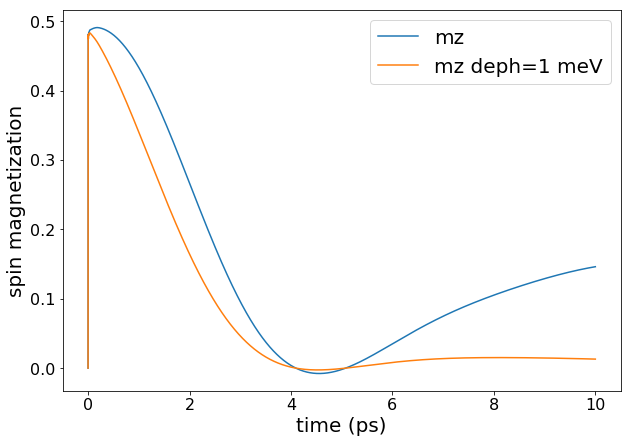

In [7]:
label_size = 20

time = spin_100['time']*1e-3 # in ps
mz = spin_100['Mc_z']
eta_cond = 1 #meV
nu = eta_cond/(U.Planck_ev_ps*1e3) # in ps

mz_deph = np.exp(-nu*time)*mz

fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(time,mz,label='mz')
ax1.plot(time,mz_deph,label='mz deph=1 meV')
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('spin magnetization',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.legend(fontsize=label_size)

#plt.savefig(fname='mz_deph.eps',format='eps',bbox_inches = "tight")
plt.show()


### Plot of the spin polarization cut at 5 ps

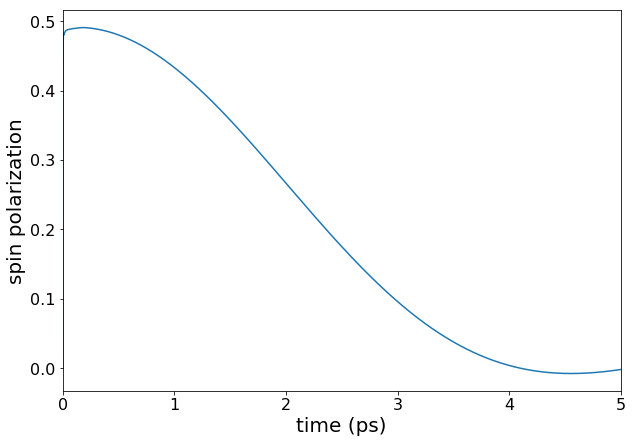

In [18]:
label_size = 20

time = spin_100['time']*1e-3 # in ps
mz = spin_100['Mc_z']

fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(time,mz,label='mz')
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('spin polarization',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.set_xlim(0,5)
#ax1.legend(fontsize=label_size)

#plt.savefig(fname='mz.eps',format='eps',bbox_inches = "tight")
plt.show()


### Plot of the spin polarization up to 20 ps. The dotted line is the contribution of the diagonal terms

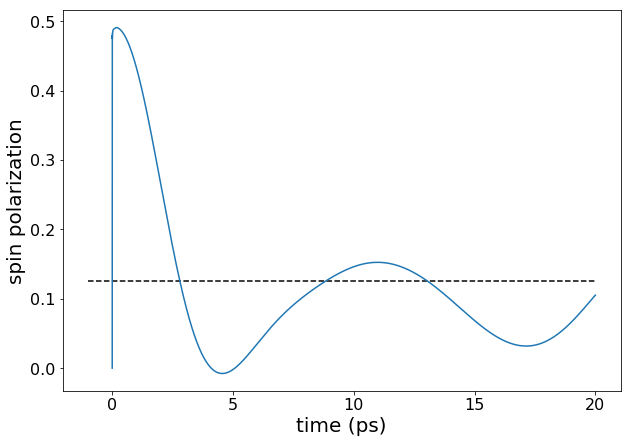

In [16]:
label_size = 20

time = spin_100_2e4_thr_1em6['time']*1e-3 # in ps
mz = spin_100_2e4_thr_1em6['Mc_z']

fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(time,mz,label='mz')
ax1.hlines(0.126,-1,20,linestyle='--')
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('spin polarization',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=16)
#ax1.set_xlim(0,5)
#ax1.legend(fontsize=label_size)

plt.show()

### Plot of the spin polarization comparing differnent k samplings and insets with carriers and profile of th field

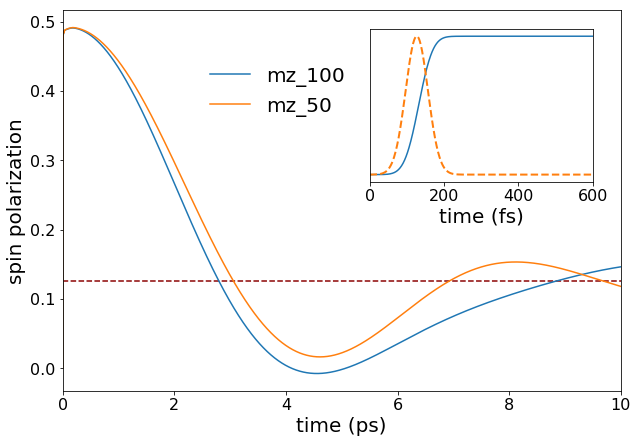

In [15]:
label_size = 20

time = spin_100['time']*1e-3 # in ps
time_thr_1em6 = spin_100_thr_1em6['time']*1e-3 # in ps
mz_100 = spin_100['Mc_z']
mz_100_thr_1em6 = spin_100_thr_1em6['Mc_z']
mz_50 = spin_50['Mc_z']

fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(time,mz_100,label='mz_100')
ax1.plot(time,mz_50,label='mz_50')
#ax1.plot(time_thr_1em6,mz_100_thr_1em6,label='mz_100_thr_1em6')
ax1.hlines(0.126,-1,11,linestyle='--',color='darkred')
ax1.set_xlim(0,10)
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('spin polarization',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=16)
ax1.legend(loc=(0.25,.7),fontsize=label_size,frameon=False)

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.55,0.55,0.4,0.4])
ax2.set_axes_locator(ip)
ax2.plot(carr_100['time'],carr_100['dne']/(max(carr_100['dne'])))
ax2.plot(field_100['time'],field_100['Intensity']/(max(field_100['Intensity'])),linestyle='--',linewidth=2)
ax2.set_xlabel('time (fs)',size=label_size)
ax2.set_yticks([])
ax2.set_xlim(0,600)
ax2.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='mz_carriers.eps',format='eps',bbox_inches = "tight")
plt.show()

### Plot of the spin polarization associated to a single k point

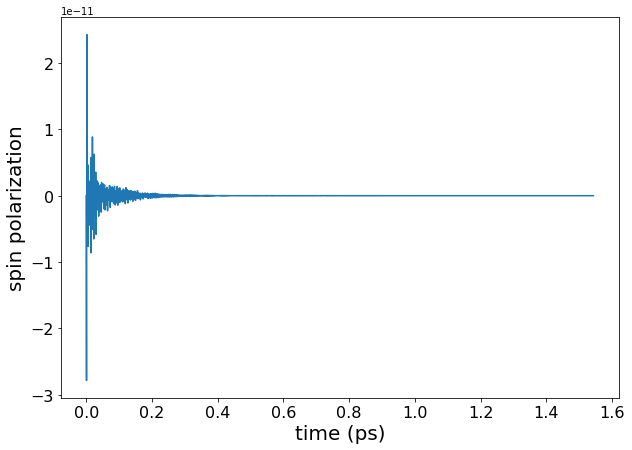

In [8]:
label_size = 20

time = spin_1k_maxfreq['time']*1e-3 # in ps
mz = spin_1k_maxfreq['Mc_z']

fig, ax1 = plt.subplots(figsize=(10, 7))
ax1.plot(time,mz,label='mz')
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('spin polarization',size=label_size)
ax1.tick_params(axis='both', which='major', labelsize=16)
#ax1.set_xlim(0,5)
#ax1.legend(fontsize=label_size)

plt.show()

In [ ]:
###############################################################################

(0, 600)

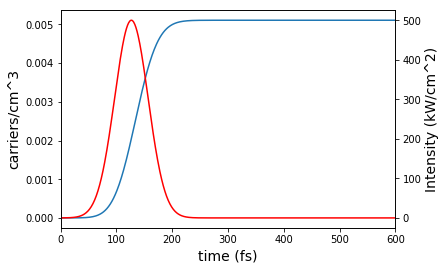

In [229]:
fig, ax1 = plt.subplots()

ax1.plot(carr_50['time'],carr_50['dne'],label='carriers')
#plt.plot(carr_100['time'],carr_100['dne'])
ax1.set_xlabel('time (fs)',size=14)
ax1.set_ylabel('carriers/cm^3',size=14)

ax2 = ax1.twinx()
ax2.plot(field_50['time'],field_50['Intensity'],label='Intensity',color='red')
ax2.set_ylabel('Intensity (kW/cm^2)',size=14)
plt.xlim(0,600)


In [384]:
spin_50 = data_50['spin_magnetization']
spin_100 = data_100['spin_magnetization']
spin_50_lowdeph = data_50_lowdeph['spin_magnetization']
spin_50_longpulse = data_50_longpulse['spin_magnetization']
#spin_100_large = data_100_large['spin_magnetization']

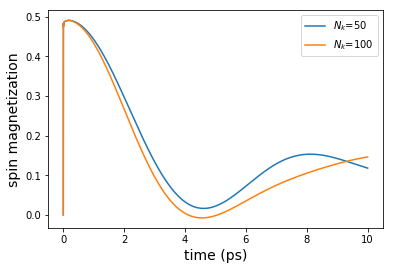

In [393]:
plt.plot(spin_50['time']*1e-3,spin_50['Mc_z'],label='$N_k$=50')
plt.plot(spin_100['time']*1e-3,spin_100['Mc_z'],label='$N_k$=100')
#plt.plot(spin_50_lowdeph['time'],spin_50_lowdeph['Mc_z'],label='50_lowdeph')
#plt.plot(spin_100_large['time'],spin_100_large['Mc_z'],label='100_large')
plt.xlabel('time (ps)',size=14)
plt.ylabel('spin magnetization',size=14)
plt.legend()

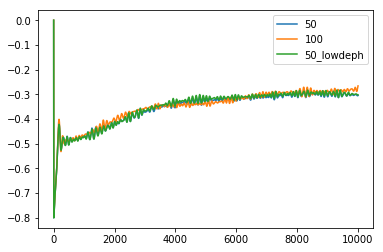

In [322]:
plt.plot(spin_50['time'],spin_50['Mv_z'],label='50')
plt.plot(spin_100['time'],spin_100['Mv_z'],label='100')
plt.plot(spin_50_lowdeph['time'],spin_50_lowdeph['Mv_z'],label='50_lowdeph')
#plt.plot(spin_100_large['time'],spin_100_large['Mv_z'],label='100')
plt.legend()

Comparison of the results with two field of different fwhm

In [337]:
field_50 = data_50['external_field']
field_50_longpulse = data_50_longpulse['external_field']

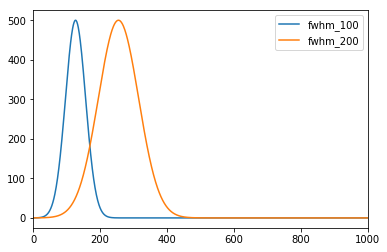

In [339]:
plt.plot(field_50['time'],field_50['Intensity'],label='fwhm_100')
plt.plot(field_50_longpulse['time'],field_50_longpulse['Intensity'],label='fwhm_200')
plt.xlim(0,1000)
plt.legend()

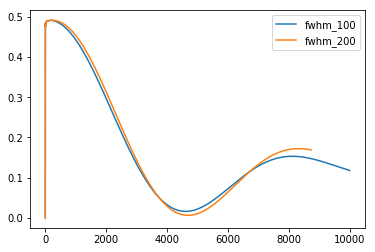

In [360]:
plt.plot(spin_50['time'],spin_50['Mc_z'],label='fwhm_100')
plt.plot(spin_50_longpulse['time'],spin_50_longpulse['Mc_z'],label='fwhm_200')

plt.legend()

## Sum of oscillatory functions

In [64]:
sim_time = 20000 # in fs
t = np.arange(0.,sim_time)

In [66]:
r_50 = P.PwParser('NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml')
r_100 = P.PwParser('NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml')
#r_200 = P.PwParser('NSCF/bnds_16-kpoints_200-sampling_random_close_Gamma.save/data-file-schema.xml')

transitions_50 = 1e3*r_50.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
transitions_100 = 1e3*r_100.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])
#transitions_200 = 1e3*r_200.get_transitions(set_gap=1.42,initial=[8,9],final=[8,9])

Parse file : NSCF/bnds_16-kpoints_50-sampling_random_close_Gamma.save/data-file-schema.xml
Parse file : NSCF/bnds_16-kpoints_100-sampling_random_close_Gamma.save/data-file-schema.xml
Apply a scissor of 0.5456147497318283 eV
Apply a scissor of 0.5456147497318283 eV


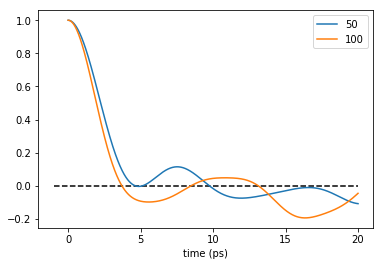

In [67]:
f_sum = 0.
for e in transitions_50:
    #print(e[0])
    nu = e[0]/(U.Planck_ev_ps*1e6)
    f_sum += np.cos(2*np.pi*nu*t)   
plt.plot(t/1000,f_sum/50,label=50)

f_sum = 0.
for e in transitions_100:
    #print(e[0])
    nu = e[0]/(U.Planck_ev_ps*1e6)
    f_sum += np.cos(2*np.pi*nu*t)
plt.plot(t/1000,f_sum/100,label=100)

#f_sum = 0.
#for e in transitions_200:
#    #print(e[0])
#    nu = e[0]/(U.Planck_ev_ps*1e6)
#    f_sum += np.cos(2*np.pi*nu*t)
#plt.plot(t/1000,f_sum/200,label=200)


plt.hlines(0,-1,20,linestyles='--')
plt.xlabel('time (ps)')
plt.legend()
plt.show()

__We observe a kpoint sampling induced damping in the time behavior of the magnetization.__

In [72]:
tt = transitions_100[0:100] 

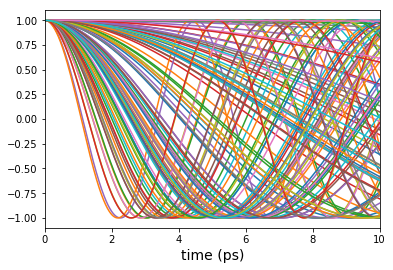

Text(0.5,0,'time (ps)')

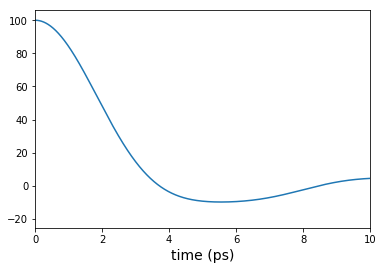

In [81]:
fsum = 0.
for e in tt:
    nu = e[0]/(U.Planck_ev_ps*1e6)
    osc = np.cos(2*np.pi*nu*t)
    fsum += osc
    plt.plot(t/1000,osc)
plt.xlim(0,10)
plt.xlabel('time (ps)',size=14)
plt.show()

plt.plot(t/1000,fsum)
plt.xlim(0,10)
plt.xlabel('time (ps)',size=14)